# Relative Elevation Model: Mendoza River

- Workflow following the [tutorial by Matt Forrest](https://github.com/mbforr/youtube-examples/tree/main/relative-elevation-model)

# Step 0: Setup

### Imports

In [97]:
#%pip install osmnx scipi xarray rioxarray matplotlib datashader -q

In [98]:
#%pip install xarray-spatial -q

In [99]:
from pathlib import Path
from IPython.core.display import Video

import numpy as np
import pandas as pd
import geopandas as gpd  # Vector data handling
import osmnx as ox       # Downloading data from OSM

from shapely.geometry import box
from scipy.spatial import cKDTree as KDTree # For Inverse Distance Weight calculation

import xarray as xr    
import xrspatial    # Hillshading
import rioxarray    # Working with geospatial data in xarray

import matplotlib.pyplot as plt
from datashader.transfer_functions import shade, stack
import geojson

## Step 1: Download & Load DEM

In [100]:
#Import dems 

dem1 = rioxarray.open_rasterio('S034W069\S034W069\ALPSMLC30_S034W069_DSM.tif')

dem2 = rioxarray.open_rasterio('S034W070\S034W070\ALPSMLC30_S034W070_DSM.tif')



In [101]:
#Join dems
dem_join = xr.combine_by_coords([dem1, dem2])

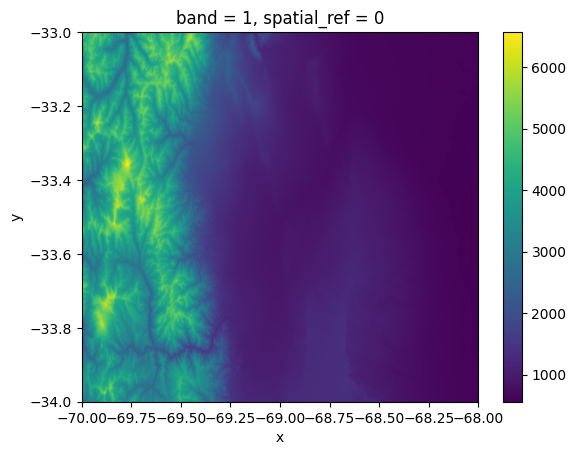

In [102]:
#plot
dem_join.plot()

Make DEM smaller and clip to focus area

In [157]:
geom = '''{"type": "Polygon",
                "coordinates":[[[-69.30909815,-33.0749051641],
                [-68.9432534319,-33.0749051641]
                ,[-68.9432534319,-32.8470882381]
                ,[-69.30909815,-32.8470882381],
                [-69.30909815,-33.0749051641]]]}'''



In [158]:
cropping_geometries = [geojson.loads(geom)]
cropped = dem_join.rio.clip(geometries=cropping_geometries, crs=4326)

In [159]:
cropped = cropped.coarsen(x=3, boundary='trim').mean().coarsen(y=3, boundary='trim').mean()

Let's plot the DEM

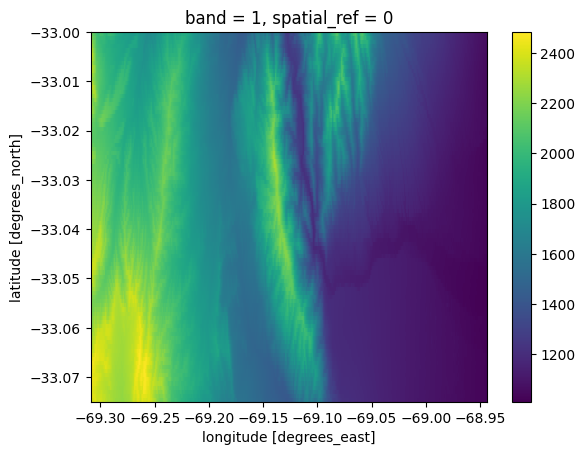

In [160]:
cropped.squeeze().plot.imshow()

## Step 2: Fetch coordinates of the river

In [161]:
river = ox.geocode_to_gdf('Mendoza River', which_result=2)
river = river.to_crs(cropped.rio.crs)

Let's plot the river

<Axes: >

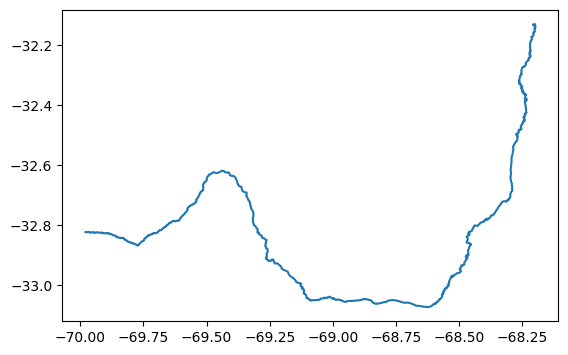

In [162]:
river.plot()

## Step 3: Cut to area of interest

#### River

In [163]:
cropped.rio.bounds()

(-69.3088888888889, -33.07472222222222, -68.94361111111112, -33.00027777777778)

In [164]:
bounds = cropped.rio.bounds()
xmin, ymin, xmax, ymax = bounds

In [165]:
river = river.clip(bounds)

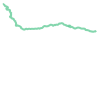

In [166]:
river_geom = river.geometry.iloc[0]
river_geom

#### DEM

In [167]:
cropped = cropped.sel(y=slice(ymax, ymin), x=slice(xmin, xmax))

Let's check if everything looks good

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

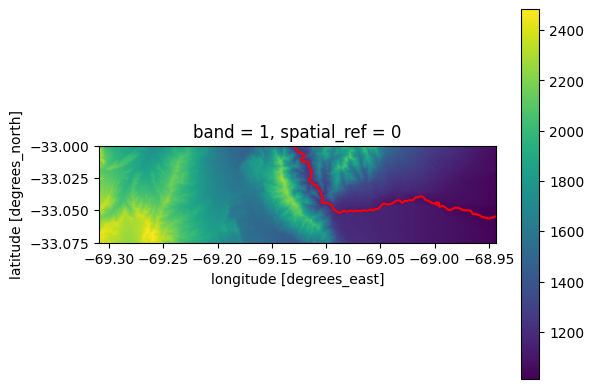

In [168]:
fig, ax = plt.subplots()
cropped.squeeze().plot.imshow(ax=ax)
river.plot(ax=ax, color='red')

## Step 4: Calculate REM

To calculate the REM, we need to 
1. Sample the elevation along the river
2. Interpolate the sampled elevation values to create a 2D elevation raster
3. Subtract the interpolated elevation raster from the DEM

### 4.1. Sample

Extract coordinates as `DataArray`

In [169]:
import shapely

def split_coords(geom):
    x = []
    y = []
    for i in shapely.get_coordinates(geom):
        x.append(i[0])
        y.append(i[1])
    return x, y
        

In [170]:
xs, ys = split_coords(river_geom)
xs, ys = xr.DataArray(xs, dims='z'), xr.DataArray(ys, dims='z')

Use xarray's [`interp`](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.interp.html#xarray.DataArray.interp) to extract the river's elevation.

In [171]:
sampled = cropped.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

### 4.2. Interpolate

Prepare data for the interpolation

In [172]:
# Sampled river coordinates
c_sampled = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T

# All (x, y) coordinates of the original DEM
c_x, c_y = [cropped.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# Sampled values
values = sampled.values.ravel()

In [173]:
c_interpolate

array([[-69.30875   , -33.00041667],
       [-69.30791667, -33.00041667],
       [-69.30708333, -33.00041667],
       ...,
       [-68.94541667, -33.07458333],
       [-68.94458333, -33.07458333],
       [-68.94375   , -33.07458333]])

Perform the interpolation. Here we use a simple implementation of [IWD](https://en.wikipedia.org/wiki/Inverse_distance_weighting) which averages the 5 nearest points, weighted by inverse distance.

In [174]:
tree

In [175]:
tree = KDTree(c_sampled)

In [176]:
# IWD interpolation
distances, indices = tree.query(c_interpolate, k=50)

weights = 1 / distances
weights = weights / weights.sum(axis=1).reshape(-1, 1)

interpolated_values = (weights * values[indices]).sum(axis=1)

In [177]:
interpolated_values

array([1258.32247798, 1258.32315851, 1258.32384545, ..., 1023.24536408,
       1023.21695348, 1023.19220577])

We create a `DataArray` out of the inerpolated values

In [178]:
elevation_raster = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

<Axes: xlabel='x', ylabel='y'>

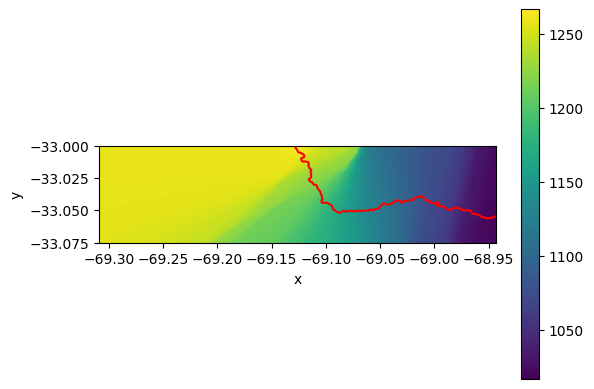

In [179]:
fig, ax = plt.subplots()
elevation_raster.transpose().plot.imshow(ax=ax)
river.plot(ax=ax, color='red')

### 4.3. Calculate

In [180]:
rem = cropped - elevation_raster

# Step 5: Visualize

Let's make some pretty REM visualizations!

In [181]:
colors = ['#f2f7fb', '#81a8cb', '#37123d']

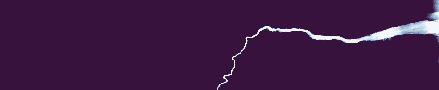

In [182]:
shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear')

We can also visualize the DEM along with the REM

c:\Users\cande\anaconda3\envs\Ass3_Pelliza\lib\site-packages\datashader\transfer_functions\__init__.py:308: RuntimeWarning: invalid value encountered in cast
  r = interp(data, span, rspan, left=255).astype(np.uint8)
c:\Users\cande\anaconda3\envs\Ass3_Pelliza\lib\site-packages\datashader\transfer_functions\__init__.py:309: RuntimeWarning: invalid value encountered in cast
  g = interp(data, span, gspan, left=255).astype(np.uint8)
c:\Users\cande\anaconda3\envs\Ass3_Pelliza\lib\site-packages\datashader\transfer_functions\__init__.py:310: RuntimeWarning: invalid value encountered in cast
  b = interp(data, span, bspan, left=255).astype(np.uint8)


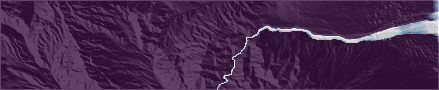

In [183]:
a = shade(xrspatial.hillshade(cropped.squeeze(), angle_altitude=1, azimuth=310), cmap=['black', 'white'], how='linear')
b = shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear', alpha=200)
stack(a, b)